# Using Genetic Algorithms for Portfolio Optimization

### 1. The Objective Function


Portfolio optimization generally involves maximizing an objective function, such as:

* Expected Return: Maximize the weighted average return of the assets.
* Risk Minimization: Minimize the portfolio variance or standard deviation.
* Maximizing the Sharpe Ratio: Maximize the risk-adjusted return.

Let's start by importing the libraries we will use:

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import random

Now, let's begin by selecting the assets. For this study, I will use four Brazilian assets, and we will try to optimize our portfolio based on them.

In [2]:
ativos = ['PETR4.SA', 'VALE3.SA', 'ITUB4.SA', 'BBDC4.SA']  # Petrobras, Vale, Itau Unibanco, Bradesco

start_date = '2020-01-01'
end_date = '2024-01-01'
dados = yf.download(ativos, start=start_date, end=end_date, auto_adjust=False)['Adj Close']

[*********************100%***********************]  4 of 4 completed


Now, we can calculate the daily returns and the covariance matrix, which will assist us in constructing our portfolio return.

In [4]:
retornos_diarios = dados.pct_change().dropna()

mean_returns = retornos_diarios.mean()
cov_matrix = retornos_diarios.cov()

For our case, we will go with the third option:
Maximizing the Sharpe Ratio: Maximizing the risk-adjusted return.

The common objective function:

\begin{equation}
    \text{Sharpe Ratio} = \frac{E[R_p] - R_f}{\sigma_p}
\end{equation}

Where:
* $E[R_p]$ is the expected return of the portfolio.
* $R_f$ is the risk-free rate.
* $\sigma_p$ is the standard deviation of the portfolio (risk).

To achieve this, I will define functions to maximize the Sharpe Ratio while ensuring that the sum of all portfolio weights equals one.

In [5]:
def portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate=0.01):
    returns = np.dot(weights, mean_returns) * 252  # Retorno anualizado
    std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)  # Risco anualizado
    sharpe_ratio = (returns - risk_free_rate) / std_dev
    return sharpe_ratio

def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.01):
    return -portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate)

def constraint(weights):
    return np.sum(weights) - 1

## 2. Chromosome Representation and Genetic Algorithm

Each chromosome represents a potential solution, that is, a set of weights assigned to each asset in the portfolio. The weights must sum to 1 (or 100%) and may have constraints like minimum and maximum limits per asset.

Example for a portfolio with 4 assets:
\begin{equation}
    \text{Chromosome} = [0.25, 0.35, 0.20, 0.20]
\end{equation}

I will generate an initial population of chromosomes randomly, ensuring that the sum of the weights equals 1 and adheres to possible constraints.

In [7]:
population_size = 50
num_assets = len(ativos)

population = [np.random.dirichlet(np.ones(num_assets), size=1)[0] for _ in range(population_size)]
population

[array([0.03933474, 0.0591868 , 0.15187684, 0.74960162]),
 array([0.31592499, 0.09728683, 0.38207554, 0.20471264]),
 array([0.26295887, 0.6319491 , 0.03636805, 0.06872399]),
 array([0.21342959, 0.50842359, 0.00573665, 0.27241018]),
 array([0.06523669, 0.17899252, 0.56976086, 0.18600992]),
 array([0.23920763, 0.24079076, 0.48046208, 0.03953953]),
 array([0.24812274, 0.5194429 , 0.18084831, 0.05158605]),
 array([0.05053351, 0.03002857, 0.68059437, 0.23884355]),
 array([0.09318149, 0.04430944, 0.0358728 , 0.82663627]),
 array([0.408413  , 0.09378117, 0.22615485, 0.27165098]),
 array([0.09018733, 0.23222034, 0.09480696, 0.58278537]),
 array([0.38391822, 0.07294612, 0.4387703 , 0.10436536]),
 array([0.31449443, 0.24958054, 0.06793763, 0.36798739]),
 array([0.06871275, 0.17092506, 0.29633954, 0.46402265]),
 array([0.06105168, 0.25648708, 0.61619959, 0.06626165]),
 array([0.05742672, 0.2628237 , 0.06685785, 0.61289173]),
 array([0.00801166, 0.39561485, 0.36054251, 0.23583098]),
 array([0.4778

Now, we evaluate each chromosome using our objective function. For this example, we are calculating the Sharpe Ratio of each asset combination and choose the best chromosomes for reproduction. Common techniques include:

* Roulette Wheel Selection: Probability proportional to fitness.
* Tournament Selection: Selection among random subsets.

Then we can combine pairs of chromosomes to create new offspring. For example:

\begin{equation}
    \text{Parent 1} = [0.3, 0.4, 0.2, 0.1]
\end{equation}

\begin{equation}
    \text{Parent 2} = [0.2, 0.3, 0.4, 0.1]
\end{equation}

Crossover result:
\begin{equation}
    \text{Child} = [0.25, 0.35, 0.3, 0.1]
\end{equation}

Also, we will introduce small random changes in the chromosomes to ensure diversity. Example:

\begin{equation}
    \text{Before Mutation} = [0.25, 0.35, 0.3, 0.1] \rightarrow [0.26, 0.34, 0.3, 0.1]
\end{equation}

Ensure that the best chromosomes from the previous generation are retained in the new generation, so good solutions are not lost.

In [9]:
num_generations = 100
mutation_rate = 0.1

for generation in range(num_generations):
    fitness_scores = [portfolio_performance(ind, mean_returns, cov_matrix) for ind in population]

    sorted_indices = np.argsort(fitness_scores)[::-1]
    population = [population[i] for i in sorted_indices[:population_size//2]]

    offspring = []
    while len(offspring) < population_size // 2:
        parents = random.sample(population, 2)
        crossover_point = np.random.randint(1, num_assets - 1)
        child = np.concatenate((parents[0][:crossover_point], parents[1][crossover_point:]))

        # Garante que todos os pesos sejam positivos
        child = np.clip(child, 0, 1)
        child /= np.sum(child)  # Normalização para manter a soma dos pesos igual a 1
        offspring.append(child)

    for i in range(len(offspring)):
        individual = offspring[i]
        if np.random.rand() < mutation_rate:
            mutation_index = np.random.randint(0, num_assets)
            mutation_value = np.random.uniform(-0.05, 0.05)

            # Aplica mutação apenas se o novo valor não for negativo
            if individual[mutation_index] + mutation_value > 0:
                individual[mutation_index] += mutation_value

            # Normalização final para garantir que todos os pesos são positivos
            individual = np.clip(individual, 0, 1)
            individual /= np.sum(individual)
        offspring[i] = individual

    population += offspring

## Choosing the Best Portolio

Now we can choose the best portfólio (the one that maximizes the Sharpe Ratio)

In [10]:
best_portfolio = max(population, key=lambda w: portfolio_performance(w, mean_returns, cov_matrix))
best_sharpe = portfolio_performance(best_portfolio, mean_returns, cov_matrix)

print("Melhor combinação de ativos:", dict(zip(ativos, best_portfolio)))
print("Melhor Índice de Sharpe:", best_sharpe)

Melhor combinação de ativos: {'PETR4.SA': 0.0011212355329919164, 'VALE3.SA': 0.00014905345365145406, 'ITUB4.SA': 0.6687005582896935, 'BBDC4.SA': 0.330029152723663}
Melhor Índice de Sharpe: 0.8590688544946978


For this analysis, we take that the best portfolio has the following ditribution:

* PETR4 = 0.11212355329919164%
* VALE3 = 0.014905345365145406%
* ITUB4 = 66.87005582896935%
* BBDC4 = 33.0029152723663%

We can see the distribuiton in a graph aswell:

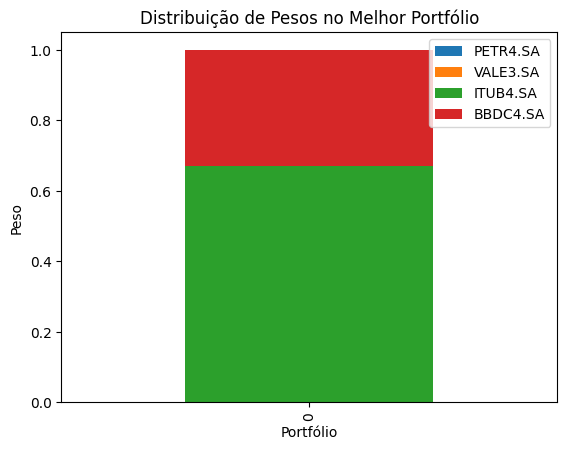

In [11]:
df_weights = pd.DataFrame({ativo: [peso] for ativo, peso in zip(ativos, best_portfolio)})
df_weights.plot(kind='bar', stacked=True)
plt.title('Distribuição de Pesos no Melhor Portfólio')
plt.ylabel('Peso')
plt.xlabel('Portfólio')
plt.show()